In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import keras

from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops
from skimage.measure import label
from tqdm import tqdm

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
%%capture
!unzip Processed.zip -d Dataset

In [3]:
# UTILS

import matplotlib.pyplot as plt
import numpy as np

def visualize_learning_curve(H):
  epochs = len(H.history["loss"])
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

from sklearn.metrics import classification_report

def evaluate_model(model, x, y):
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x, batch_size=128)
  print(classification_report(y, predictions.argmax(axis=1)))

In [4]:
# Constants

labels = ['FBO1', 'FEAR5', 'FEC', 'FGI4', 'FSA12', 'FSV41']

In [5]:
import pandas as pd
import cv2
from tqdm import tqdm

df = pd.read_csv("Dataset/Processed/labels_train.csv", index_col=0)

image_data = []
image_labels = []

for i in tqdm(range(len(df))):
  img = cv2.imread(f"Dataset/Processed/Train/cacao-{i}.jpg")
  image_data.append(img)

image_data = np.array(image_data)
image_labels = df["class"].values

100%|██████████| 1612/1612 [00:00<00:00, 3421.12it/s]


In [6]:
label_encoder = LabelEncoder()
image_labels_int = label_encoder.fit_transform(image_labels)

# Convert labels to categorical (one-hot encoded)
image_labels_cat = to_categorical(image_labels_int)

In [7]:
# Step 3: Split the Data into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels_cat, test_size=0.2, random_state=42)


In [8]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(image_labels_int),
    y=image_labels_int
)

class_weight_dict = dict(zip(np.unique(image_labels_int), class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.8395833333333333, 1: 0.9426900584795321, 2: 0.9426900584795321, 3: 0.9426900584795321, 4: 0.9426900584795321, 5: 1.7675438596491229}


In [25]:
from tensorflow.keras.regularizers import l2

# Step 5: Build the CNN Model

model = Sequential([
    Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(0.001), activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(0.001), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(0.001), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(0.001), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(0.001), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(0.001), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dense(len(labels), activation='softmax')  # Output layer with one unit per class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 100, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,729,574 (37.12 MB)

 Trainable params: 9,728,678 (37.11 MB)

 Non-trainable params: 896 (3.50 KB)

In [26]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, verbose=1, min_lr=1e-5)
]

datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True
)

# Fit the generator on your training data
datagen.fit(X_train)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - accuracy: 0.3549 - loss: 9.0499 - val_accuracy: 0.2291 - val_loss: 32.6409 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.6110 - loss: 1.3482 - val_accuracy: 0.2229 - val_loss: 33.8459 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.6710 - loss: 1.1964 - val_accuracy: 0.2074 - val_loss: 24.3941 - learning_rate: 0.0010
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7411 - loss: 1.0489 - val_accuracy: 0.2848 - val_loss: 10.3101 - learning_rate: 0.0010
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7972 - loss: 0.8949 - val_accuracy: 0.3158 - val_loss: 6.7608 - learning_rate: 0.0010
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.8260 - loss: 0.8037 - val_accuracy: 0.2972 - val_loss: 11.9092 - learning_rate: 0.0010
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8223 - loss: 0.8862 - val_accur

In [32]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Step 8: Save the Model
model.save('cacao_bean_cnn_model.h5')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9418 - loss: 0.4976


Validation Accuracy: 0.9474


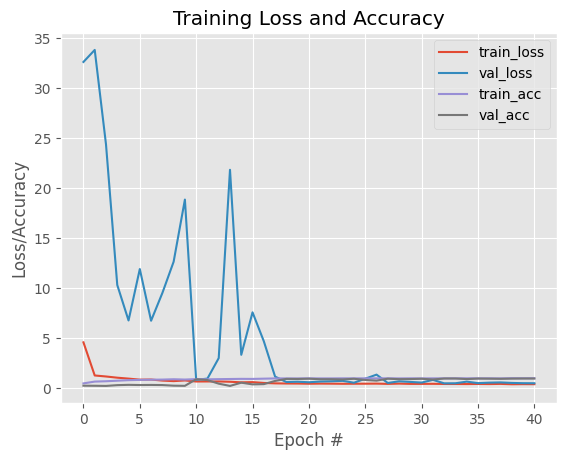

In [28]:
visualize_learning_curve(history)

# TESTING

In [29]:
%%capture
!unzip Test.zip -d Test

In [21]:
def process_image(image):

    # Resize once and convert to grayscale
    image_resized = cv2.resize(image, (500, 300))
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

    # Thresholding and hole filling
    _, img = cv2.threshold(image_gray, 0, 1, cv2.THRESH_OTSU)
    img = 1 - img
    img = binary_fill_holes(img)

    # Calculate largest bounding box using regionprops
    lab, num = label(img, return_num=True)
    max_area = 0
    bbox = []

    for i in range(1, num + 1):
        object_region = (lab == i).astype('uint8')
        prop = regionprops(object_region)[0]
        area = prop.area
        if area > max_area:
            max_area = area
            bbox = prop.bbox


    # If max_area is too small, skip processing (early exit)
    if max_area < 1000:
        print(f"Max area too small: {max_area}")
        return None

    # Crop the image and apply the mask
    img_cropped = image_resized[bbox[0]: bbox[2], bbox[1]: bbox[3]]
    mask_cropped = img[bbox[0]: bbox[2], bbox[1]:bbox[3]]
    img_cropped = img_cropped * mask_cropped[..., None]

    old_image_height, old_image_width, channels = img_cropped.shape

    # create new image of desired size and color (blue) for padding
    new_image_width = 300
    new_image_height = 300
    color = (0,0,0)
    result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image
    result[y_center:y_center+old_image_height,
        x_center:x_center+old_image_width] = img_cropped

    result = cv2.resize(result, (100,100))


    return result


In [22]:
df = pd.read_csv("labels_test.csv")

df.head()

classes = np.unique(df["Class"])

images_test = []
labels_test = []


for i in tqdm(range(len(df))):
  path = df.iloc[i]["Image path"].replace("Dataset", "Test")


  image = cv2.imread(path)
  image = process_image(image)
  images_test.append(image)
  labels_test.append(df.iloc[i]["Class"])


100%|██████████| 180/180 [00:25<00:00,  6.99it/s]


In [30]:
predictions = []

for i in images_test:
  single_image = np.expand_dims(i, axis=0)
  predictions.append(labels[np.argmax(model.predict(single_image, verbose=0))])



              precision    recall  f1-score   support

        FBO1       0.94      1.00      0.97        30
       FEAR5       0.91      1.00      0.95        30
         FEC       1.00      0.97      0.98        30
        FGI4       0.97      0.93      0.95        30
       FSA12       0.92      0.73      0.81        30
       FSV41       0.91      1.00      0.95        30

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180



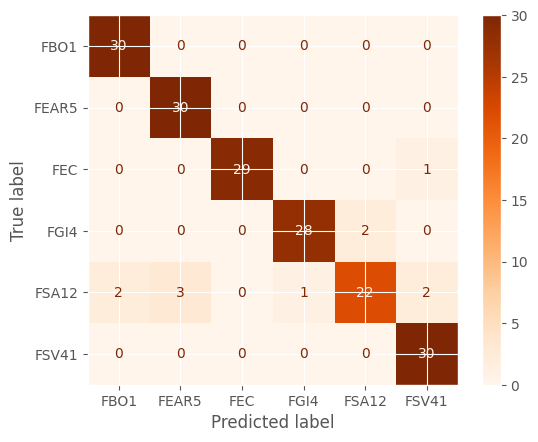

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

report = classification_report(labels_test, predictions)
print(report)

cm = confusion_matrix(labels_test, predictions)
confusion_matrix_display = ConfusionMatrixDisplay(cm, display_labels=classes)
confusion_matrix_display.plot(cmap="Oranges")